# Calculate CAA scavenging rates from observations

Dissolved trace metal data from Manuel Colombo, particulate trace metal data from Jingxuan Li.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
import seaborn as sns; sns.set()

warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# Concentration of dMn in 2015
# Manuel = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Fe&Mn_Integrated_Data_UBC-UVic_4-17-19_editedBR.csv')
Manuel = pd.read_csv('/ocean/brogalla/GEOTRACES/data/DMn_nmolL-1_BR-edited.csv')
Manuel_station_names = Manuel['Station'].astype('string')
Manuel_depths        = Manuel['Depth'].astype('float')
Manuel_dMn_nmolkg    = Manuel['nmol kg-1'].astype('float')
Manuel_dMn_nmolL     = Manuel['nmol L-1'].astype('float')

Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = Pb_data['Station names'].dropna().astype('str')
lons = Pb_data['station lon'].astype('float').dropna().values
lats = Pb_data['Station lat'].astype('float').dropna().values

In [4]:
# Load particulate data
pMn_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/pTM_Maldonado_DATA_v2_notes.csv')
stns = pMn_data['GEOTR_STN'].astype('str')

For each station, find a similar depth:

In [5]:
def assoc_depth(name):
    
    pMn_stn   = pMn_data['Mn (pmol/L)'].where(stns == name).dropna().astype('float').values*1e-3
    dMn_stn   = Manuel_dMn_nmolL[Manuel_station_names==name].values
    depth_pMn = pMn_data['CTDPRS (DBAR)'].where(stns == name).dropna().astype('float').values
    depth_dMn = Manuel_depths[Manuel_station_names==name].values
    
    if len(depth_pMn) > len(depth_dMn):
        depth_list    = np.array(depth_pMn)
        depth_shorter = np.array(depth_dMn)
    else:
        depth_list    = np.array(depth_dMn)
        depth_shorter = np.array(depth_pMn)

    depths= np.empty_like(depth_list)
    pMn   = np.empty_like(depth_list)
    dMn   = np.empty_like(depth_list)
    i=0

    for depth in depth_list:
        min_val  = np.argmin(np.abs(depth_shorter - depth))
        
        if np.abs(depth_shorter[min_val] - depth) > 80:
            depths[i] = np.nan
            pMn[i]    = np.nan
            dMn[i]    = np.nan
        else:
            depths[i] = depth_shorter[min_val]
            if len(depth_pMn) > len(depth_dMn):
                pMn[i]    = pMn_stn[i]
                dMn[i]    = dMn_stn[min_val]                
            else:
                pMn[i]    = pMn_stn[min_val]
                dMn[i]    = dMn_stn[i] #indexed starting with 1 instead of 0 (removed + 1)
        i+=1
        
    return depths, pMn, dMn

In [6]:
# 2015: no pMn data for CAA2
depths_CAA1, pmn_CAA1, dmn_CAA1 = assoc_depth('CAA1')
depths_CAA3, pmn_CAA3, dmn_CAA3 = assoc_depth('CAA3')
depths_CAA4, pmn_CAA4, dmn_CAA4 = assoc_depth('CAA4')
depths_CAA5, pmn_CAA5, dmn_CAA5 = assoc_depth('CAA5')
depths_CAA6, pmn_CAA6, dmn_CAA6 = assoc_depth('CAA6')
depths_CAA7, pmn_CAA7, dmn_CAA7 = assoc_depth('CAA7')
depths_CAA8, pmn_CAA8, dmn_CAA8 = assoc_depth('CAA8')
depths_CAA9, pmn_CAA9, dmn_CAA9 = assoc_depth('CAA9')

depths_CB1, pmn_CB1, dmn_CB1 = assoc_depth('CB1')
depths_CB2, pmn_CB2, dmn_CB2 = assoc_depth('CB2')
depths_CB3, pmn_CB3, dmn_CB3 = assoc_depth('CB3')
depths_CB4, pmn_CB4, dmn_CB4 = assoc_depth('CB4')

depths_BB1, pmn_BB1, dmn_BB1 = assoc_depth('BB1')
depths_BB2, pmn_BB2, dmn_BB2 = assoc_depth('BB2')
depths_BB3, pmn_BB3, dmn_BB3 = assoc_depth('BB3')

## Calculating scavenging rates:

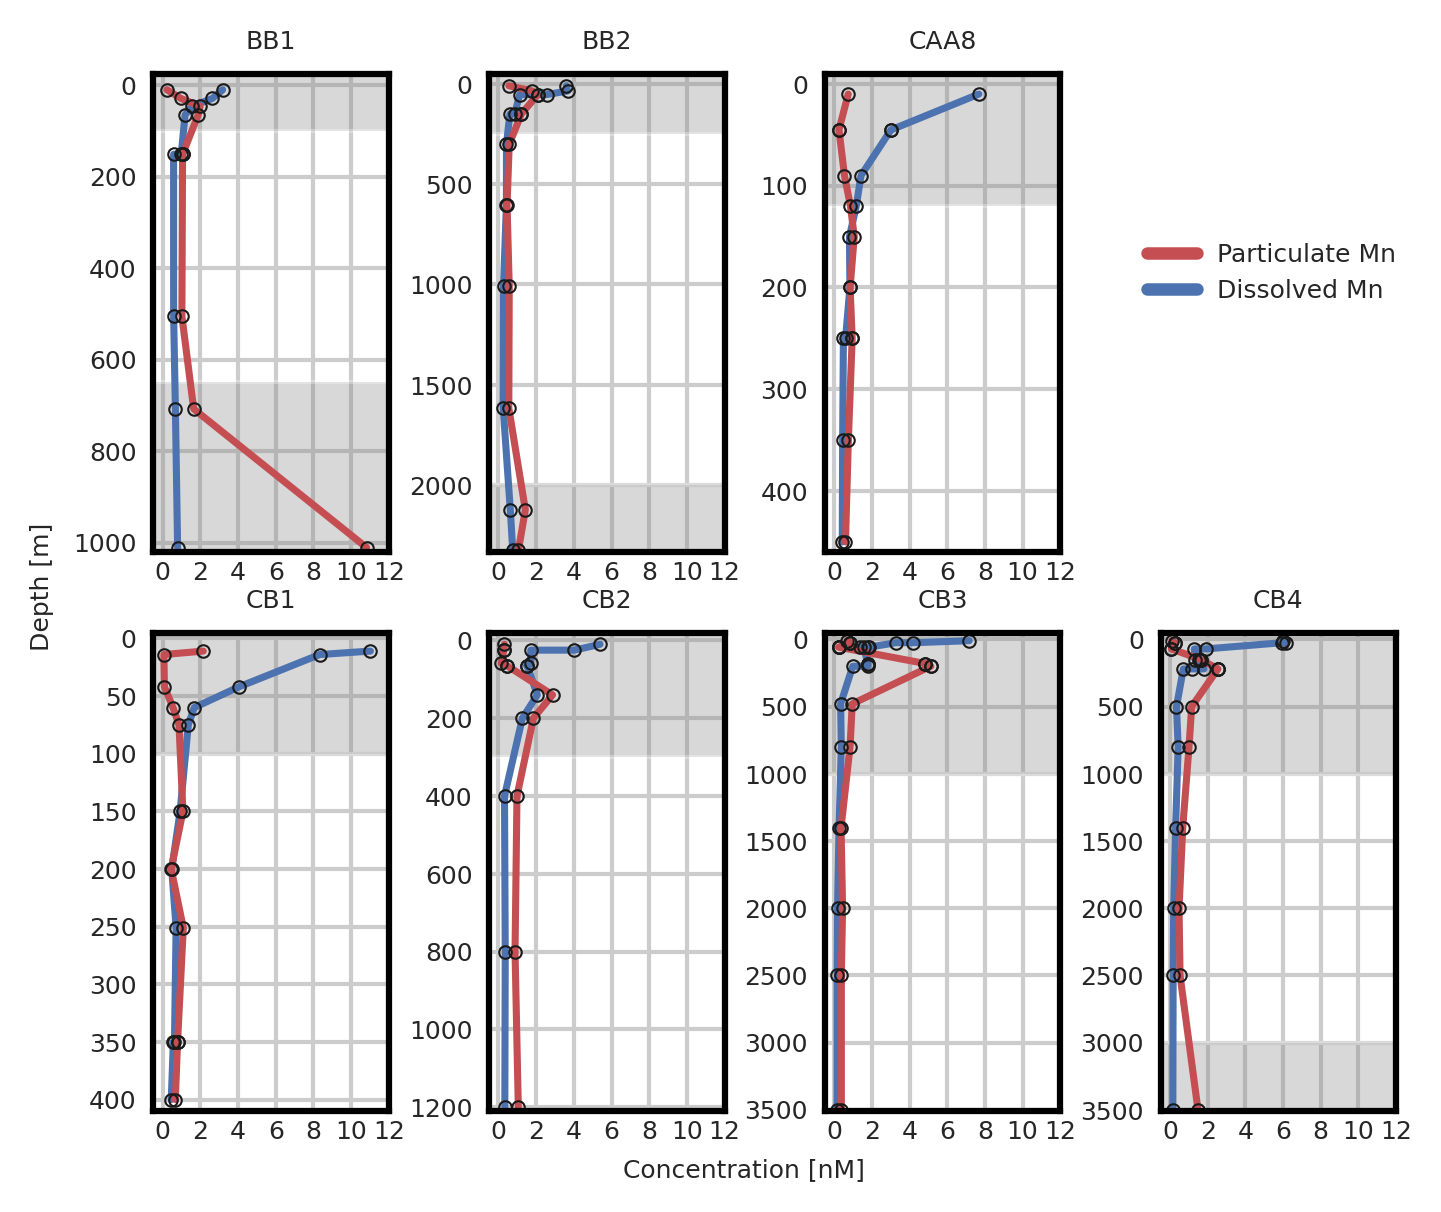

In [10]:
st = sns.axes_style("whitegrid")

with plt.rc_context({"xtick.major.pad": -4, "ytick.major.pad": -2}):
    with st:
        fig, ax = plt.subplots(2,4, figsize=(4.5, 3.74), dpi=300)
        
        for axs in ax.ravel():
            axs.invert_yaxis()
            axs.set_xlim([-0.5, 12])
            axs.tick_params(axis='both', which='major', labelsize=6)
            axs.set_xticks([0,2,4,6,8,10,12])
            axs.spines['left'].set_linewidth(1.5);   axs.spines['left'].set_color('black');
            axs.spines['bottom'].set_linewidth(1.5); axs.spines['bottom'].set_color('black');
            axs.spines['right'].set_linewidth(1.5);  axs.spines['right'].set_color('black');
            axs.spines['top'].set_linewidth(1.5);    axs.spines['top'].set_color('black');

        ax[0,3].axis('off')

        ax[0,0].plot(dmn_BB1[~np.isnan(dmn_BB1)], depths_BB1[~np.isnan(dmn_BB1)], '-', linewidth=1.7)
        ax[0,1].plot(dmn_BB2[~np.isnan(dmn_BB2)], depths_BB2[~np.isnan(dmn_BB2)], '-', linewidth=1.7)
        ax[0,2].plot(dmn_CAA8[~np.isnan(dmn_CAA8)], depths_CAA8[~np.isnan(dmn_CAA8)], '-', linewidth=1.7)
        ax[0,0].plot(pmn_BB1[~np.isnan(pmn_BB1)], depths_BB1[~np.isnan(pmn_BB1)], '-r', linewidth=1.7)
        ax[0,1].plot(pmn_BB2[~np.isnan(pmn_BB2)], depths_BB2[~np.isnan(pmn_BB2)], '-r', linewidth=1.7)
        ax[0,2].plot(pmn_CAA8[~np.isnan(pmn_CAA8)], depths_CAA8[~np.isnan(pmn_CAA8)], '-r', linewidth=1.7)
        ax[0,0].plot(dmn_BB1[~np.isnan(dmn_BB1)], depths_BB1[~np.isnan(dmn_BB1)], 'ok', fillstyle='none', markersize=3, markeredgewidth=0.5)
        ax[0,1].plot(dmn_BB2[~np.isnan(dmn_BB2)], depths_BB2[~np.isnan(dmn_BB2)], 'ok', fillstyle='none', markersize=3, markeredgewidth=0.5)
        ax[0,2].plot(dmn_CAA8[~np.isnan(dmn_CAA8)], depths_CAA8[~np.isnan(dmn_CAA8)], 'ok', fillstyle='none', markersize=3, markeredgewidth=0.5)
        ax[0,0].plot(pmn_BB1[~np.isnan(pmn_BB1)], depths_BB1[~np.isnan(pmn_BB1)], 'ok', fillstyle='none', markersize=3, markeredgewidth=0.5)
        ax[0,1].plot(pmn_BB2[~np.isnan(pmn_BB2)], depths_BB2[~np.isnan(pmn_BB2)], 'ok', fillstyle='none', markersize=3, markeredgewidth=0.5)
        ax[0,2].plot(pmn_CAA8[~np.isnan(pmn_CAA8)], depths_CAA8[~np.isnan(pmn_CAA8)], 'ok', fillstyle='none', markersize=3, markeredgewidth=0.5)

        ax[1,0].plot(dmn_CB1[~np.isnan(dmn_CB1)], depths_CB1[~np.isnan(dmn_CB1)], '-', linewidth=1.7)
        ax[1,1].plot(dmn_CB2[~np.isnan(dmn_CB2)], depths_CB2[~np.isnan(dmn_CB2)], '-', linewidth=1.7)
        ax[1,2].plot(dmn_CB3[~np.isnan(dmn_CB3)], depths_CB3[~np.isnan(dmn_CB3)], '-', linewidth=1.7)
        ax[1,3].plot(dmn_CB4[~np.isnan(dmn_CB4)], depths_CB4[~np.isnan(dmn_CB4)], '-', linewidth=1.7)
        ax[1,0].plot(pmn_CB1[~np.isnan(pmn_CB1)], depths_CB1[~np.isnan(pmn_CB1)], '-r', linewidth=1.7)
        ax[1,1].plot(pmn_CB2[~np.isnan(pmn_CB2)], depths_CB2[~np.isnan(pmn_CB2)], '-r', linewidth=1.7)
        ax[1,2].plot(pmn_CB3[~np.isnan(pmn_CB3)], depths_CB3[~np.isnan(pmn_CB3)], '-r', linewidth=1.7)
        ax[1,3].plot(pmn_CB4[~np.isnan(pmn_CB4)], depths_CB4[~np.isnan(pmn_CB4)], '-r', linewidth=1.7)
        ax[1,0].plot(dmn_CB1[~np.isnan(dmn_CB1)], depths_CB1[~np.isnan(dmn_CB1)], 'ok', fillstyle='none', markersize=3, markeredgewidth=0.5)
        ax[1,1].plot(dmn_CB2[~np.isnan(dmn_CB2)], depths_CB2[~np.isnan(dmn_CB2)], 'ok', fillstyle='none', markersize=3, markeredgewidth=0.5)
        ax[1,2].plot(dmn_CB3[~np.isnan(dmn_CB3)], depths_CB3[~np.isnan(dmn_CB3)], 'ok', fillstyle='none', markersize=3, markeredgewidth=0.5)
        ax[1,3].plot(dmn_CB4[~np.isnan(dmn_CB4)], depths_CB4[~np.isnan(dmn_CB4)], 'ok', fillstyle='none', markersize=3, markeredgewidth=0.5)
        ax[1,0].plot(pmn_CB1[~np.isnan(pmn_CB1)], depths_CB1[~np.isnan(pmn_CB1)], 'ok', fillstyle='none', markersize=3, markeredgewidth=0.5)
        ax[1,1].plot(pmn_CB2[~np.isnan(pmn_CB2)], depths_CB2[~np.isnan(pmn_CB2)], 'ok', fillstyle='none', markersize=3, markeredgewidth=0.5)
        ax[1,2].plot(pmn_CB3[~np.isnan(pmn_CB3)], depths_CB3[~np.isnan(pmn_CB3)], 'ok', fillstyle='none', markersize=3, markeredgewidth=0.5)
        ax[1,3].plot(pmn_CB4[~np.isnan(pmn_CB4)], depths_CB4[~np.isnan(pmn_CB4)], 'ok', fillstyle='none', markersize=3, markeredgewidth=0.5)

        #grey boxes:
        ax[0,0].fill_between([-2,20], [-25,-25], [100,100], facecolor='grey', alpha=0.3)
        ax[0,0].fill_between([-2,20], [650,650], [np.nanmax(depths_BB1)+80, np.nanmax(depths_BB1)+80], facecolor='grey', alpha=0.3)
        ax[0,0].set_ylim([np.nanmax(depths_BB1)+10, -25])
        ax[0,1].fill_between([-2,20], [-50,-50] , [250, 250], facecolor='grey', alpha=0.3)
        ax[0,1].fill_between([-2,20], [2000,2000], [np.nanmax(depths_BB2)+80, np.nanmax(depths_BB2)+80], facecolor='grey', alpha=0.3)
        ax[0,1].set_ylim([np.nanmax(depths_BB2)+10, -50])
        ax[0,2].fill_between([-2,20], [-10,-10]    , [120, 120], facecolor='grey', alpha=0.3)
        ax[0,2].set_ylim([np.nanmax(depths_CAA8)+10, -10])

        ax[1,0].fill_between([-2,20], [-10,-10]  ,[100,100], facecolor='grey', alpha=0.3)
        ax[1,0].set_ylim([np.nanmax(depths_CB1)+10, -5])
        ax[1,1].fill_between([-2,20], [-20,-20]  ,[300,300], facecolor='grey', alpha=0.3)
        ax[1,1].set_ylim([np.nanmax(depths_CB2)+10, -20])
        ax[1,2].fill_between([-2,20], [-50,-50]  ,[1000,1000], facecolor='grey', alpha=0.3)
        ax[1,2].set_ylim([np.nanmax(depths_CB3)+10, -50])
        ax[1,3].fill_between([-2,20], [-50,-50]  ,[1000,1000], facecolor='grey', alpha=0.3)
        ax[1,3].fill_between([-2,20], [3000,3000], [np.nanmax(depths_CB4)+80, np.nanmax(depths_CB4)+80], facecolor='grey', alpha=0.3)
        ax[1,3].set_ylim([np.nanmax(depths_CB4)+10, -50])

        ax[0,3].plot(-1,2, '-r', linewidth=3, label='Particulate Mn')
        ax[0,3].plot(-1,2, '-', linewidth=3, label='Dissolved Mn')

        ax[0,0].set_title('BB1', fontsize=6)
        ax[0,1].set_title('BB2', fontsize=6)
        ax[0,2].set_title('CAA8', fontsize=6)
        ax[1,0].set_title('CB1', fontsize=6)
        ax[1,1].set_title('CB2', fontsize=6)
        ax[1,2].set_title('CB3', fontsize=6)
        ax[1,3].set_title('CB4', fontsize=6)

        ax[0,3].legend(loc=(-0.1,0.5), frameon=False, fontsize=6)

        fig.text(0.5, -0.02, 'Concentration [nM]', ha='center', va='center', fontsize=6)
        fig.text(-0.02, 0.5, 'Depth [m]', ha='center', va='center', rotation='vertical', fontsize=6)

        plt.tight_layout(pad=0.1)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/S4-scavenging-stns.jpg', bbox_inches='tight', dpi=300)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/S4-scavenging-stns.svg', bbox_inches='tight', dpi=300, format='svg')

In [ ]:
# Arrays of observations at locations far away from sources:
dmn = np.concatenate((dmn_BB1[(depths_BB1 > 100) & (depths_BB1 < 650)], \
                      dmn_BB2[(depths_BB2 > 250) & (depths_BB2 < 2000)], \
                      dmn_CAA8[(depths_CAA8 > 120) & (depths_CAA8 < 500)], \
                      dmn_CB1[(depths_CB1 > 100) & (depths_CB1 < 400)], \
                      dmn_CB2[(depths_CB2 > 300) & (depths_CB2 < 1250)], \
                      dmn_CB3[depths_CB3 > 500], \
                      dmn_CB4[(depths_CB4 > 1000) & (depths_CB4 < 3000)]))
pmn = np.concatenate((pmn_BB1[(depths_BB1 > 100) & (depths_BB1 < 650)], \
                      pmn_BB2[(depths_BB2 > 250) & (depths_BB2 < 2000)], \
                      pmn_CAA8[(depths_CAA8 > 120) & (depths_CAA8 < 500)], \
                      pmn_CB1[(depths_CB1 > 100) & (depths_CB1 < 400)], \
                      pmn_CB2[(depths_CB2 > 300) & (depths_CB2 < 1250)], \
                      pmn_CB3[depths_CB3 > 500], \
                      pmn_CB4[(depths_CB4 > 1000) & (depths_CB4 < 3000)]))

In [37]:
print(f'{mean_squared_error(pmn_fit, model.predict(dmn_fit), squared=False):.2f}')

0.25


slope:  [1.4653572]
score:  <bound method RegressorMixin.score of LinearRegression(fit_intercept=False)>


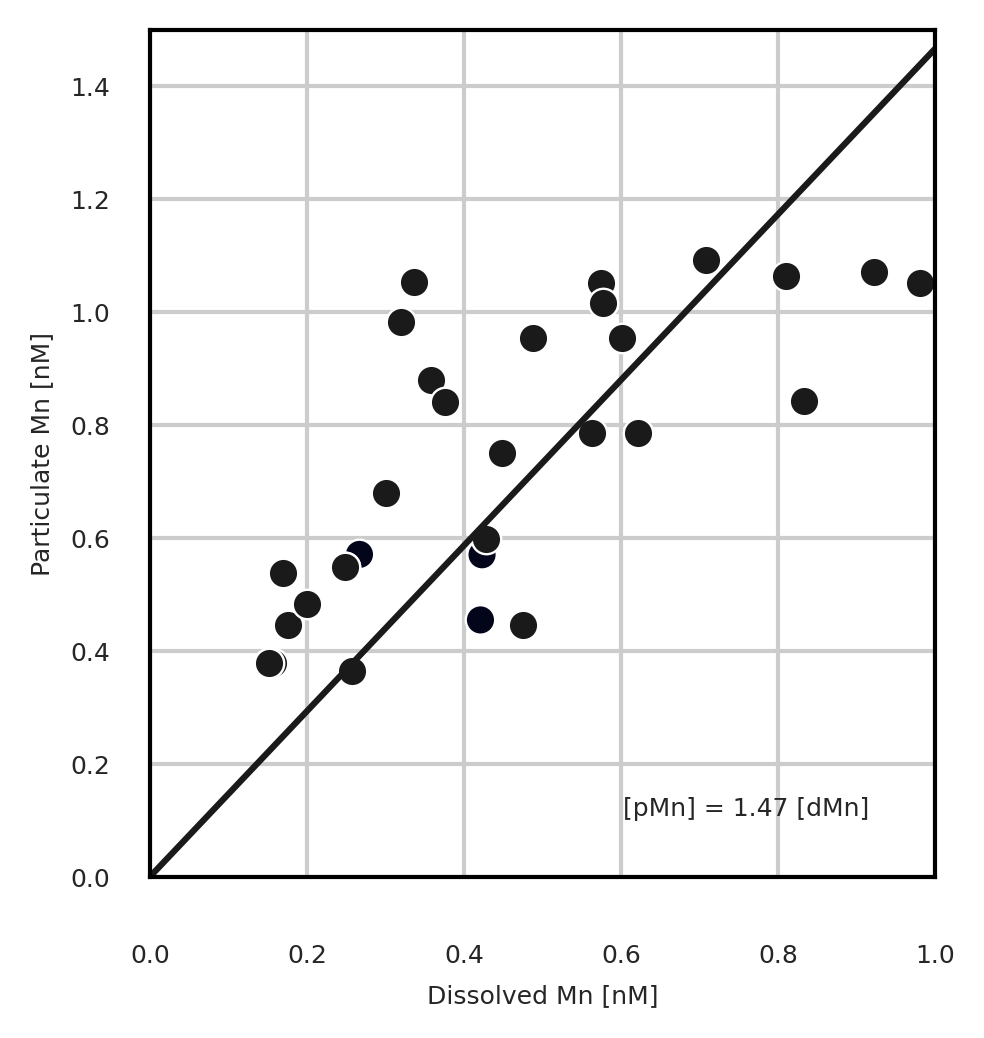

In [38]:
fig = plt.figure(figsize=(4.5*0.75, 3.74), dpi=300)

xp      = np.linspace(0,1.0,20)
xp_fit  = xp.reshape((-1, 1)) 
dmn_fit = dmn.reshape((-1, 1))
pmn_fit = pmn
model   = LinearRegression(fit_intercept=False).fit(dmn_fit, pmn_fit)
r_sq    = model.score(dmn_fit, pmn_fit)
yp_pred = model.predict(xp_fit)
print('slope: ', model.coef_)
print('score: ', model.score)

st = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(xp, yp_pred, c='k')

    sns.scatterplot(dmn_BB1[(depths_BB1 > 100) & (depths_BB1 < 650)],  \
                    pmn_BB1[(depths_BB1 > 100) & (depths_BB1 < 650)],  s=50, color='k')
    sns.scatterplot(dmn_BB2[(depths_BB2 > 250) & (depths_BB2 < 2000)], \
                    pmn_BB2[(depths_BB2 > 250) & (depths_BB2 < 2000)], s=50, color='k')
    sns.scatterplot([dmn_BB2[(depths_BB2 > 250) & (depths_BB2 < 2000)][3]], \
                    [pmn_BB2[(depths_BB2 > 250) & (depths_BB2 < 2000)][3]], s=50, color='k') # plot twice, otherwise color messes up somehow
    sns.scatterplot(dmn_CAA8[(depths_CAA8 > 120) & (depths_CAA8 < 500)], \
                    pmn_CAA8[(depths_CAA8 > 120) & (depths_CAA8 < 500)], s=50, color='k')
    sns.scatterplot(dmn_CB1[(depths_CB1 > 100) & (depths_CB1 < 400)], \
                    pmn_CB1[(depths_CB1 > 100) & (depths_CB1 < 400)], s=50, color='k')
    sns.scatterplot(dmn_CB2[(depths_CB2 > 300) & (depths_CB2 < 1250)], \
                    pmn_CB2[(depths_CB2 > 300) & (depths_CB2 < 1250)], s=50, color='k')
    sns.scatterplot(dmn_CB3[depths_CB3 > 500], \
                    pmn_CB3[depths_CB3 > 500], s=50, color='k')
    sns.scatterplot(dmn_CB4[(depths_CB4 > 1000) & (depths_CB4 < 3000)], \
                    pmn_CB4[(depths_CB4 > 1000) & (depths_CB4 < 3000)], s=50, color='k')

    ax.set_ylabel('Particulate Mn [nM]', fontsize=6)
    ax.set_xlabel('Dissolved Mn [nM]', fontsize=6)
    ax.set(ylim=(0,1.5), xlim=(0,1.0))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    
    
    ax.text(0.76, 0.08,'[pMn] = 1.47 [dMn]', fontsize=6, horizontalalignment='center', \
            verticalalignment='center', transform=ax.transAxes);

fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S5-scavenging-rate.png', bbox_inches='tight', dpi=300)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S5-scavenging-rate.svg', bbox_inches='tight', dpi=300, format='svg')